In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

sns.set()
sns.set_style(style="whitegrid")
sns.set_color_codes("colorblind")

# Network Dynamics and Learning - Homework I

## Exercise 1

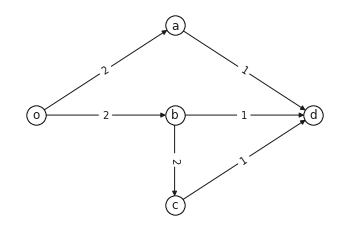

In [2]:
# defnition of the graph
G = nx.DiGraph()
G.add_edges_from(["oa", "ob", "bc"], capacity=2)
G.add_edges_from(["ad", "bd", "cd"], capacity=1)
pos = {'o': [-1, 0],
       'a': [0, 1],
       'b': [0, 0],
       'c': [0, -1],
       'd': [1, 0]}

# plot
labels = {(t, h): G[t][h]["capacity"] for t, h in G.edges()}

nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000")
nx.draw(G, pos, node_color="#ffffff", with_labels=True)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/e1_graph.pdf", bbox_inches="tight")

* What is the minimum aggregate capacity that needs to be removed for no feasible flow from o to d to exist?

To have no feasible flow we should cut remove all the capacity fro the min-cut from o to d. In this way we are removing the minimal aggragate capacity from the network.

In [3]:
cut_capacity, partitions = nx.minimum_cut(G, "o", "d")

cut_edges = []
for t in partitions[0]:
    for h in partitions[1]:
        if (t, h) in list(G.edges()):
            cut_edges.append(str((t, h)))

print(f"Minimum aggragate capacity to be removed: {cut_capacity}")
print("Removed from the edges: \n", "\n".join(cut_edges), sep="")

Minimum aggragate capacity to be removed: 3
Removed from the edges: 
('b', 'd')
('a', 'd')
('c', 'd')


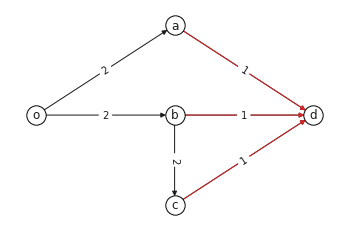

In [4]:
# plot
labels = {(t, h): G[t][h]["capacity"] for t, h in G.edges()}

nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
nx.draw(G, pos, node_color="#ffffff", with_labels=True)
nx.draw_networkx_edges(G, pos, edgelist=[("a", "d"), ("b", "d"), ("c", "d")],width=1,edge_color="tab:red")

plt.savefig("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/e1_1.pdf", bbox_inches="tight")

* What is the maximum aggregate capacity that can be removed from the links without affecting the maximum throughput from o to d?

To find the maximum amount of capacity we can remove from the graph while still having the same maximum flow we compute the minimum graph that has that same flow.

1) We compute the edges that are part of the minimal cut

2) We set to one the value of all the edges that are not in the set just coputed

3) Recursively we try to add a capacity of 1 the edges to which we just removed the capacity. The graph having the same maximum flow with the minimum recursive depth is the optimal solution we are seeking for.

4) The difference in capacity of the original graph and the optimal one just found is the maximum capacity we can remove.

We can remove up to 2 units of capacity from the original grpah still maintaining the flow.
Removed from the edges: 
('o', 'a')
('b', 'c')


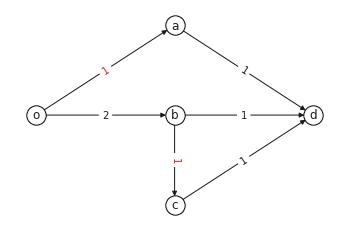

In [5]:
from copy import deepcopy
from collections import deque
from itertools import combinations

def find_minimum_cuts(G, s, t):
    """
    This function computes all the possible cuts and return only the minimal ones
    """
    internal_nodes = set(G.nodes()) - {s, t}  # selects nodes that are neither s nor t

    cuts = []  # list with possible cuts
    # for any combination of nodes and respective cut we compute the capacity of the cut
    for k in range(len(internal_nodes)+1):
        for item in combinations(internal_nodes, k):
            S = set(item).union({s})  # elements on s side
            T = set(G.nodes()) - S  # elements on t side

            cap = 0  # capacity of the cut
            E = []  # edges in the cut
            for t in S:
                for h in T:
                    if (t, h) in G.edges():  # if the edge is in the graph
                        cap += G[t][h]["capacity"]  # add its capacity to the one
                                                    # of the cut
                        E.append((t, h))  # add the edge to the list

            cuts.append({"edges": E, "capacity": cap})

    min_cap = min([c["capacity"] for c in cuts])  # computes the minimal capacity
    # returns only cuts with minimal capacity
    return [set(c["edges"]) for c in cuts if c["capacity"] == min_cap]

def candidate_edges(G, s, t):
    """
    This function is used to compute the set of edges that are not included in
    the minimal cut.
    """
    cuts = find_minimum_cuts(G, s, t)
    min_edges = cuts[0]
    for i in range(1, len(cuts)):
        min_edges = min_edges.union(cuts[i])

    # return the edges not between those that were in the minimal cut
    return [e for e in G.edges() if e not in min_edges] 

def find_minimal_cap_rec(G, s, t, target_flow, candidates, depth, added, _max_rec):
    """
    This recursive function computes the minimal graph that would have the same
    maximum flow of the original one testing different capacity value for all the
    edges that were not included in the minimum cut of the original graph
    """
    optimal_added, optimal_depth = None, _max_rec

    if depth >= _max_rec:  # return if we exceeded the maximal number of recursions
        return None, None

    if nx.maximum_flow_value(G, s, t) == target_flow:  # recursion stop criterion
        return deepcopy(added), depth

    it = 0
    for tail, head in candidates:
        it += 1
        G[tail][head]["capacity"] += 1
        added.append((tail, head))  # add to the queue the edge on which we added
                                    # the capacity
        prop_added, prop_depth = find_minimal_cap_rec(G, s, t, target_flow,
                                                      candidates, depth+1, added,
                                                      _max_rec)  # recursion
        # check for optimal solution
        if prop_depth and prop_depth < optimal_depth:
            optimal_depth = prop_depth
            optimal_added = prop_added

        G[tail][head]["capacity"] -= 1 # restore to previous step state
        added.pop()  # remove from the queue the edge
    
    return optimal_added, optimal_depth


# definition of the secondary graph with all non-mincut edges set to 1
Gprime = deepcopy(G)
candidates = candidate_edges(Gprime, "o", "d")
for t, h in candidates:
    Gprime[t][h]["capacity"] = 1

# total capacities of the original and the secondary graph, used in the stopping
# criterion for exceeded recursions
capG = sum([G[t][h]["capacity"] for t, h in G.edges()])
capGprime = sum([Gprime[t][h]["capacity"] for t, h in Gprime.edges()])

# compute the edge on which we need to add the capacity to reach the minimal-capacitated
# graph with target flow
added, _ = find_minimal_cap_rec(Gprime, "o", "d",
                                target_flow=nx.maximum_flow_value(G, "o", "d"),
                                candidates=candidates,
                                depth=0, added=deque(), _max_rec=capG-capGprime)

# add capacity to the edges selected by recursion
for t, h in added:
    Gprime[t][h]["capacity"] += 1

# compute statistics
removed_cap = sum([G[t][h]["capacity"] - Gprime[t][h]["capacity"] for t, h in G.edges()])
where_was_removed = [str((t, h)) for t, h in G.edges() if G[t][h]["capacity"] != Gprime[t][h]["capacity"]]

print(f"We can remove up to {removed_cap} units of capacity from the original grpah still maintaining the flow.")
print("Removed from the edges: \n", "\n".join(where_was_removed), sep="")

# plot
labels = {(t, h): Gprime[t][h]["capacity"] for t, h in Gprime.edges()}

nx.draw_networkx_edge_labels(Gprime, pos, edge_labels=labels)
nx.draw_networkx_edge_labels(Gprime, pos, edge_labels={("o", "a"): Gprime["o"]["a"]["capacity"], ("b", "c"): Gprime["b"]["c"]["capacity"]}, font_color="tab:red")
nx.draw_networkx_nodes(Gprime, pos, linewidths=3, edgecolors="#000000")
nx.draw(Gprime, pos, node_color="#ffffff", with_labels=True)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/e1_2.pdf", bbox_inches="tight")

* You are given $x > 0$ extra units of capacity. How should you distribute them in order to maximize the throughput that can be sent from o to d? Plot the maximum throughput from o to d as a function of $x ≥ 0$.



Capacity added on: (a->d)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (c->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity added on: (o->b)
Capacity added on: (b->d)
Capacity add

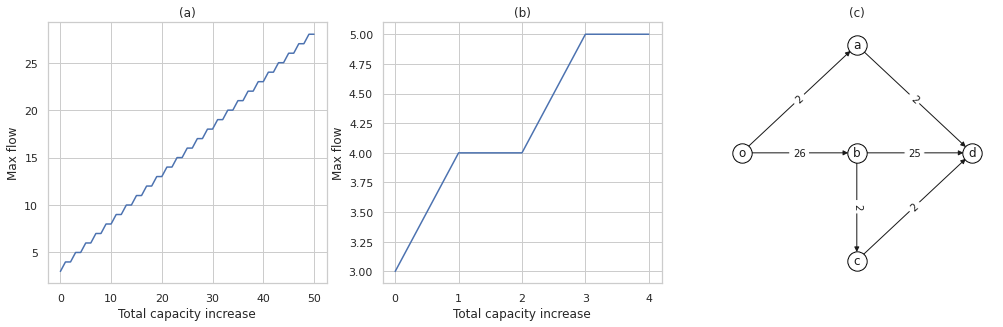

In [6]:
from copy import deepcopy

df = pd.DataFrame(columns=["x", "max_flow"])
Gprime = deepcopy(G)
df.loc[len(df)] = [0, nx.maximum_flow_value(Gprime, "o", "d")]

for x in range(1, 51):
    minimal_cuts = find_minimum_cuts(Gprime, "o", "d")  # find minimal cuts for actual state

    # compute the set of all edges in a cut with minimal capacities
    all = minimal_cuts[0]
    for i in range(1, len(minimal_cuts)):
        all = all.union(minimal_cuts[i])

    all = list(all)
        
    # compute in how many cuts each edge is in
    stats = [0] * len(all)
    for i, e in enumerate(all):
        for cut in minimal_cuts:
            if e in cut:
                stats[i] += 1
    
    max_presences = max(stats)  # maximum number of minimal cuts in which an edge is
    # take only the edges with the maximum number of presences
    bests = [e for i, e in enumerate(all) if stats[i]==max_presences]
    # from them find the edge with minimal capacity
    t, h = min(bests, key=lambda e: Gprime[e[0]][e[1]]["capacity"])
    Gprime[t][h]["capacity"] += 1  # increase its capacity

    print(f"Capacity added on: ({t}->{h})")

    df.loc[len(df)] = [x, nx.maximum_flow_value(Gprime, "o", "d")]

# plots
fig, ax = plt.subplots(1, 3, figsize=(17, 4.8))
ax[0].set_title("(a)")
sns.lineplot(data=df, x="x", y="max_flow", ax=ax[0])
ax[0].set_ylabel("Max flow")
ax[0].set_xlabel("Total capacity increase")
ax[1].set_title("(b)")
sns.lineplot(data=df.loc[0:4], x="x", y="max_flow", ax=ax[1])
ax[1].set_ylabel("Max flow")
ax[1].set_xlabel("Total capacity increase")
ax[2].set_title("(c)")
labels = {(t, h): Gprime[t][h]["capacity"] for t, h in Gprime.edges()}
nx.draw_networkx_edge_labels(Gprime, pos, edge_labels=labels, ax=ax[2])
nx.draw_networkx_nodes(Gprime, pos, linewidths=3, edgecolors="#000000", ax=ax[2])
nx.draw(Gprime, pos, node_color="#ffffff", with_labels=True, ax=ax[2])

plt.savefig("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/e1_3.pdf", bbox_inches="tight")

## Exercise 2

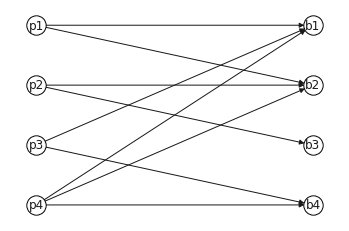

In [7]:
# defnition of the graph
G = nx.DiGraph()
G.add_nodes_from([f"p{i}" for i in range(1, 5)], layer=1)
G.add_nodes_from([f"b{i}" for i in range(1, 5)], layer=2)
G.add_edges_from([("p1", "b1"), ("p1", "b2"), ("p2", "b2"), ("p2", "b3"),
                  ("p3", "b1"), ("p3", "b4"), ("p4", "b1"), ("p4", "b2"),
                  ("p4", "b4")])
pos = nx.multipartite_layout(G, subset_key="layer")

# plot
nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000")
nx.draw(G, pos, node_color="#ffffff", with_labels=True)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/e2_graph.pdf", bbox_inches="tight")

Gprime = deepcopy(G)

* Exploit max-flow problems to find a perfect matching (if any).

To do this we have to modify the graph:

1) add high capacity to the links already available (networkx considers infinite capacity for nodes without capacity attribute)

2) add a source node connected with 1-capacitated links to all the p-nodes

3) add a destination node with 1-capacitated links from all b-nodes

In [8]:
# graph modifications
G.add_nodes_from(["o"], layer=0)
G.add_nodes_from(["d"], layer=3)
G.add_edges_from([("o", "p1"), ("o", "p2"), ("o", "p3"), ("o", "p4"),
                  ("b1", "d"), ("b2", "d"), ("b3", "d"), ("b4", "d")], capacity=1)
pos = nx.multipartite_layout(G, subset_key="layer")

The largest matching has the same cardinality of the flow on this graph.

In [9]:
flow, flow_description = nx.maximum_flow(G, "o", "d")

# extract from the results the matching that was obatined
optimal_matching = []
optimal_matching_edges = []
for person in flow_description:
    if "p" in person:
        for book, value in flow_description[person].items():
            if value == 1:
                optimal_matching.append(str((person, book)))
                optimal_matching_edges.append((person, book))

print(f"The maximum matching cardinality is: {flow}")
print("With optimal matching: \n", "\n".join(optimal_matching), sep="")

The maximum matching cardinality is: 4
With optimal matching: 
('p1', 'b2')
('p2', 'b3')
('p3', 'b1')
('p4', 'b4')


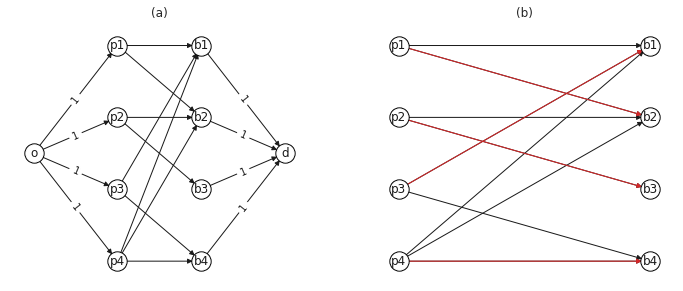

In [10]:
# plots
fig, ax = plt.subplots(1, 2, figsize=(12, 4.8))

ax[0].set_title("(a)")
pos1 = nx.multipartite_layout(G, subset_key="layer")
labels = {(t, h): G[t][h]["capacity"] for t, h in G.edges() if t=="o" or h=="d"}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax[0])
nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000", ax=ax[0])
nx.draw(G, pos, node_color="#ffffff", with_labels=True, ax=ax[0])

ax[1].set_title("(b)")
pos2 = nx.multipartite_layout(Gprime, subset_key="layer")
nx.draw_networkx_nodes(Gprime, pos, linewidths=3, edgecolors="#000000", ax=ax[1])
nx.draw(Gprime, pos, node_color="#ffffff", with_labels=True, ax=ax[1])
nx.draw_networkx_edges(Gprime, pos, edgelist=optimal_matching_edges, width=1, edge_color="tab:red", ax=ax[1])

plt.savefig("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/e2_1mod.pdf", bbox_inches="tight")

It is a complete matching.

* Assume now that there are multiple copies books, and the distribution of the number of copies is (2, 3, 2, 2). Each person can take an arbitrary number of different books. Exploit the analogy with max-flow problems to establish how many books of interest can be assigned in total.

To do so we have to modify again the structure of the graph:

1) add infinite capacity to links between o and p-nodes

2) set to 1 the capacity of each link between p- and b-nodes

3) set the capacity of the link b$_i$-d to the quantity defined for the $i^{th}$ book

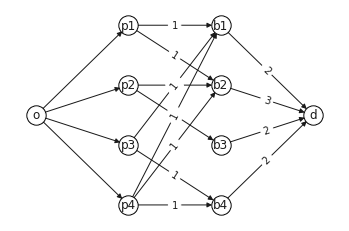

In [11]:
# modification of the graph
for t, h in G.edges():
    if "o" in t:
        G[t][h]["capacity"] = np.Inf
    elif "p" in t:
        G[t][h]["capacity"] = 1
    elif t == "b1" or t == "b3" or t == "b4":
        G[t][h]["capacity"] = 2
    else:
        G[t][h]["capacity"] = 3

# plot
labels = {(t, h): G[t][h]["capacity"] for t, h in G.edges() if "p" in t or "b" in t}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000")
nx.draw(G, pos, node_color="#ffffff", with_labels=True)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/e2_2.pdf", bbox_inches="tight")

The amount of books of interest that can be assigned is equal to the maximum flow on this graph. 

In [12]:
flow, flow_description = nx.maximum_flow(G, "o", "d")

# extract from the results the matching that was obatined
optimal_matching = []
optimal_matching_edges = []
for person in flow_description:
    if "p" in person:
        for book, value in flow_description[person].items():
            if value == 1:
                optimal_matching.append(str((person, book)))
                optimal_matching_edges.append((person, book))

print(f"The maximum matching cardinality is: {flow}")
print("With optimal matching: \n", "\n".join(optimal_matching), sep="")

The maximum matching cardinality is: 8
With optimal matching: 
('p1', 'b2')
('p2', 'b2')
('p2', 'b3')
('p3', 'b1')
('p3', 'b4')
('p4', 'b1')
('p4', 'b2')
('p4', 'b4')


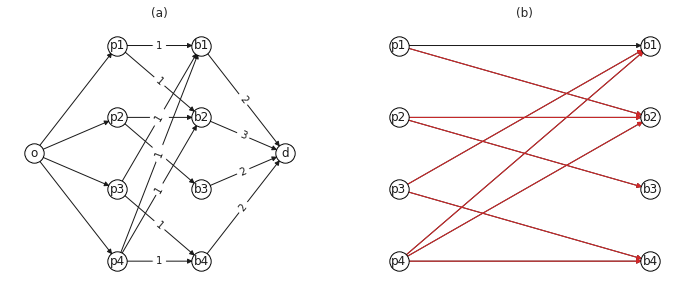

In [13]:
# plots
fig, ax = plt.subplots(1, 2, figsize=(12, 4.8))

ax[0].set_title("(a)")
pos1 = nx.multipartite_layout(G, subset_key="layer")
labels = {(t, h): G[t][h]["capacity"] for t, h in G.edges() if t!="o"}
nx.draw_networkx_edge_labels(G, pos1, edge_labels=labels, ax=ax[0])
nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000", ax=ax[0])
nx.draw(G, pos, node_color="#ffffff", with_labels=True, ax=ax[0])

ax[1].set_title("(b)")
pos2 = nx.multipartite_layout(Gprime, subset_key="layer")
nx.draw_networkx_nodes(Gprime, pos2, linewidths=3, edgecolors="#000000", ax=ax[1])
nx.draw(Gprime, pos, node_color="#ffffff", with_labels=True, ax=ax[1])
nx.draw_networkx_edges(Gprime, pos, edgelist=optimal_matching_edges, width=1, edge_color="tab:red", ax=ax[1])

plt.savefig("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/e2_2mod.pdf", bbox_inches="tight")

* Suppose that the library can sell a copy of a book and buy a copy of another book. Which books should be sold and bought to maximize the number of assigned books?

To solve this problem we can iteratively try to reduce by 1 the capacity of each b$_i$-d link and consequently try to increase by 1 the capacity of another b$_i$-d link. Then if the resulting graph has a maximum flow greater than the result obtained with the default graph we obatined a new optimal library confguration.

The optimal matching we can find has cardinality: 9
Obtained selling a copy of b3 and buying a copy of b1


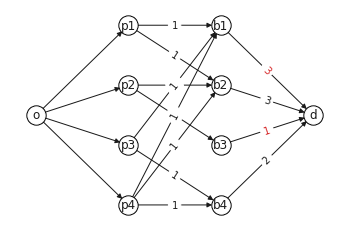

In [14]:
candidates = set([(t, h) for t, h in G.edges() if h == "d"])

max_flow = nx.maximum_flow_value(G, "o", "d")  # initial optimal result
removed, added = None, None

# cycle over all the candidates
for e in candidates:
    t, h = e
    G[t][h]["capacity"] -= 1  # remove the capacity of 1 from the selected link

    # cycle over the remaining links
    for t2, h2 in (candidates - {e}):
        G[t2][h2]["capacity"] += 1  # add the capacity 1 to another link
        flow = nx.maximum_flow_value(G, "o", "d")

        if flow > max_flow:  # better result found
            max_flow = flow
            removed = (t, h)
            added = (t2, h2)

        G[t2][h2]["capacity"] -= 1  # restore initial conditions
    
    G[t][h]["capacity"] += 1  # restore initial conditions

print(f"The optimal matching we can find has cardinality: {max_flow}")
if added:
    print(f"Obtained selling a copy of {removed[0]} and buying a copy of {added[0]}")
else:
    print("Obtained with no change in library's composition")

# apply modifications
G[removed[0]][removed[1]]["capacity"] -= 1
G[added[0]][added[1]]["capacity"] += 1

# plot
labels = {(t, h): G[t][h]["capacity"] for t, h in G.edges() if "p" in t or "b" in t}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000")
nx.draw(G, pos, node_color="#ffffff", with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={("b1", "d"): G["b1"]["d"]["capacity"], ("b3", "d"): G["b3"]["d"]["capacity"]}, font_color="tab:red")

plt.savefig("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/e2_3.pdf", bbox_inches="tight")

## Exercise 3

In [15]:
from scipy import io as io

f = io.loadmat("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/data/flow.mat")["flow"].reshape(28,)
c = io.loadmat("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/data/capacities.mat")["capacities"].reshape(28,)
B = io.loadmat("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/data/traffic.mat")["traffic"]
l = io.loadmat("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/data/traveltime.mat")["traveltime"].reshape(28,).astype(float)

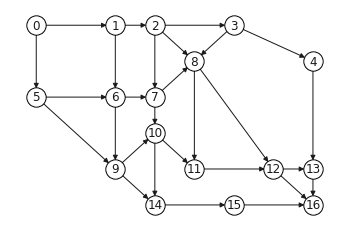

In [16]:
# definition of the graphs
G = nx.DiGraph()

edges = []

for j in range(B.shape[1]):
    t = np.where(B[:, j]==1)[0][0]
    h = np.where(B[:, j]==-1)[0][0]

    G.add_edge(t, h, capacity=c[j], traveltime=l[j])

    edges.append((t, h))

pos = {
    0: [0, 5], 1: [2, 5], 2: [3, 5], 3: [5, 5], 4: [7, 4],
    5: [0, 3], 6: [2, 3], 7: [3, 3], 8: [4, 4], 9: [2, 1],
    10: [3, 2], 11: [4, 1], 12: [6, 1], 13: [7, 1],
    14: [3, 0], 15: [5, 0], 16: [7, 0]
}

# plots
nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000")
nx.draw(G, pos, node_color="#ffffff", with_labels=True)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/e3_graph.pdf", bbox_inches="tight")

* Find the shortest path between node 0 and 16. This is equivalent to the fastest path (path with shortest traveling time) in an empty network.

In [17]:
!pip install --upgrade cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import cvxpy as cxp

# definition of exogenous flow vector nu
v = np.zeros(len(G.nodes()))
v[0] = 1
v[-1] = -1

# construction of the problem
flow = cxp.Variable(len(G.edges()))
objective = cxp.sum(cxp.multiply(flow, l))  # objective for shortest path: sum over e f_e * l_e
constraints = [B @ flow == v, flow >= 0]

problem = cxp.Problem(cxp.Minimize(objective), constraints)

# solution
sol = problem.solve()
opt_flow = flow.value

# detect the used edges as the edges with flow 1
used = []
for i in range(len(edges)):
    if np.isclose(opt_flow[i], 1):
        used.append(edges[i])

# reorder the edges so that we can identify the path
ordered = [e for e in used if e[0]==0]
used.remove(ordered[0])
while len(used) > 0:
    next = [e for e in used if e[0]==ordered[-1][1]]
    ordered += next
    used.remove(next[0])

print("The shortest path is:")
print(" -> ".join([str(e) for e in ordered]))
print(f"with toatl traveltime: {sol}")

The shortest path is:
(0, 1) -> (1, 2) -> (2, 8) -> (8, 12) -> (12, 16)
with toatl traveltime: 0.532996000033922


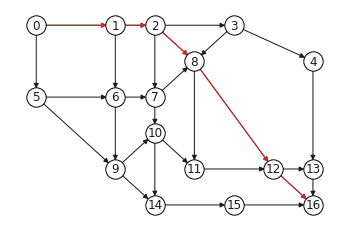

In [19]:
#plots
nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000")
nx.draw(G, pos, node_color="#ffffff", with_labels=True)
nx.draw_networkx_edges(G, pos, edgelist=ordered, edge_color="tab:red")

plt.savefig("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H1/e3_1.pdf", bbox_inches="tight")

* Find the maximum flow between node 1 and 17.

In [20]:
flow, flow_description = nx.maximum_flow(G, 0, 16)

print(f"The maximum flow on that graph is: {flow}")

The maximum flow on that graph is: 22448


* Given the flow vector in flow.mat, compute the external inflow ν satisfying Bf = ν

In [21]:
v = B @ f

print(v)

[ 16806   8570  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]


In [22]:
inflow = sum([max(e, 0) for e in v])

print(f"The total external inflow is: {inflow}.")

The total external inflow is: 56131.


In the following, we assume that the exogenous inflow is zero in all the nodes except for node 1, for which ν1 has the same value computed above, and node 17, for which ν17 = −ν1.

* Find the social optimum $f^*$ with respect to the delays on the different links $d_e(f_e)$. For this, minimize the cost function
$$\sum_{e \in \mathcal{E}} f_ed_e(f_e)=\sum_{e \in \mathcal{E}} \frac{f_el_e}{1 - f_e/c_e} = \sum_{e \in \mathcal{E}} \bigg(\frac{l_ec_e}{1 - f_e/c_e} - l_ec_e\bigg)$$
subject to the flow constraints.

In [23]:
# definition of the exogenous flows vector
v = np.zeros(v.shape)
v[0], v[-1] = 16806, -16806

In [24]:
# problem construction
flow = cxp.Variable(B.shape[1])
objective = cxp.sum(
    cxp.multiply(cxp.multiply(l, c),
                 cxp.inv_pos(1 - cxp.multiply(flow, cxp.inv_pos(c))))
    - cxp.multiply(l, c)
)  # objective written as i the 3rd form above
constraints = [B @ flow == v, flow >= 0]

so_problem = cxp.Problem(cxp.Minimize(objective), constraints)

# solution of the problem
so_sol = so_problem.solve()
so_flow = flow.value

print("Social optimal flow:", so_flow)
print("Social optimum cost:", so_sol)

Social optimal flow: [6.64230051e+03 6.05889802e+03 3.13240161e+03 3.13240145e+03
 1.01636995e+04 4.63840047e+03 3.00636212e+03 2.54258815e+03
 3.13151936e+03 5.83402485e+02 1.26113499e-03 2.92649515e+03
 1.56756001e-04 3.13240145e+03 5.52529902e+03 2.85430437e+03
 4.88643549e+03 2.21544084e+03 4.63775232e+02 2.33756409e+03
 3.31807944e+03 5.65564353e+03 2.37304293e+03 1.63316053e-04
 6.41411997e+03 5.50544438e+03 4.88643565e+03 4.88643565e+03]
Social optimum cost: 25943.621934951483


* Find the Wardrop equilibrium $f^{(0)}$. For this, use the cost function
$$\sum_{e \in \mathcal{E}} \int_0^{f_e} d_e(s) ds = \sum_{e \in \mathcal{E}} -l_ec_e(log(c_e-f_e) - log(c_e))$$

In [25]:
# construction of the problem
flow = cxp.Variable(B.shape[1])
objective = cxp.sum(
    - cxp.multiply(cxp.multiply(l, c),
                   cxp.log(c - flow) - cxp.log(c))
)  # objective as defined solving the integral
constraints = [B @ flow == v, flow >= 0]

uo_problem = cxp.Problem(cxp.Minimize(objective), constraints)

# solution of the problem
uo_sol = uo_problem.solve()
uo_flow = flow.value

print("Wardrop optimal flow:", uo_flow)
print("Wardrop optimal cost:", uo_sol)

Wardrop optimal flow: [6.71564887e+03 6.71564494e+03 2.36740693e+03 2.36740660e+03
 1.00903510e+04 4.64539458e+03 2.80384448e+03 2.28356200e+03
 3.41848060e+03 3.93236508e-03 1.76827141e+02 4.17141087e+03
 3.27483440e-04 2.36740660e+03 5.44495644e+03 2.35317195e+03
 4.93333851e+03 1.84155403e+03 6.97109625e+02 3.03649260e+03
 3.05028112e+03 6.08677373e+03 2.58651209e+03 4.53191804e-04
 6.91874224e+03 4.95391869e+03 4.93333897e+03 4.93333897e+03]
Wardrop optimal cost: 15729.607069782058


In [26]:
def cost(f):
    return np.sum(f * l / (1 - f / c))

print(f"PoA(Wardrop's equilibrium) = {cost(uo_flow)/so_sol}")

PoA(Wardrop's equilibrium) = 1.013465411189913


* Introduce tolls, such that the toll on link e is $\omega_e = f_e^*d_e'(f_e^*)$ where $f_e^*$ is the flow at the system optimum. Now the delay on link e is given by $d_e(f_e) + \omega_e$. compute the new Wardrop equilibrium $f^{(\omega)}$. What do you observe?

$$\omega_e = f_e^* \frac{c_el_e}{(c_e - f_e^*)^2}$$

In [27]:
# construction of the problem
flow = cxp.Variable(B.shape[1])
omega = so_flow * ((l * c) / (c - so_flow)**2)  # tolls constructed as defined by the derivative
objective = cxp.sum(
    cxp.multiply(omega, flow)
    - cxp.multiply(cxp.multiply(l, c),
                   cxp.log(c - flow) - cxp.log(c))
)  # objective function with tolls
constraints = [B @ flow == v, flow >= 0]

uo_toll_problem = cxp.Problem(cxp.Minimize(objective), constraints)

# solving the problem
uo_toll_sol = uo_toll_problem.solve()
uo_toll_flow = flow.value

print("Wardrop optimal flow with tolls:", uo_toll_flow)
print("Wardrop optimal cost with tolls:", uo_toll_sol)

Wardrop optimal flow with tolls: [6.64230497e+03 6.05906927e+03 3.13229856e+03 3.13229846e+03
 1.01636950e+04 4.63801355e+03 3.00624924e+03 2.54244535e+03
 3.13154038e+03 5.83235692e+02 3.93931146e-04 2.92677032e+03
 9.82142899e-05 3.13229846e+03 5.52568145e+03 2.85425237e+03
 4.88642908e+03 2.21500000e+03 4.63804288e+02 2.33767538e+03
 3.31805653e+03 5.65573192e+03 2.37316608e+03 1.23277585e-04
 6.41410622e+03 5.50546454e+03 4.88642920e+03 4.88642920e+03]
Wardrop optimal cost with tolls: 61885.968586118914


In [28]:
print(f"PoA(Wardrop's equilibrium with tolls) = {cost(uo_toll_flow)/so_sol}")

PoA(Wardrop's equilibrium with tolls) = 0.9999999943670447


* Instead of the total travel time, let the cost for the system be the total additional delay compared to the total delay in free flow, given by
$$\psi_e(f_e) = f_e(d_e(f_e) - l_e)$$
subject to the flow constraints. Compute the system optimum $f^*$ for the costs above. Construct tolls $\omega^*$ such that the Wardrop equilibrium $f^{(\omega^*)}$ coincides with $f^*$. Compute the new Wardrop equilibrium with the constructed tolls $f^{(\omega^*)}$ to verify your result.

In [29]:
# construction of the problem
flow = cxp.Variable(B.shape[1])
objective = cxp.sum(
    cxp.multiply(cxp.multiply(l, c),
                 cxp.inv_pos(1 - cxp.multiply(flow, cxp.inv_pos(c))))
    - cxp.multiply(l, c)
) - l.T @ flow
constraints = [B @ flow == v, flow >= 0]

so_problem2 = cxp.Problem(cxp.Minimize(objective), constraints)

# solving the problem
so_sol2 = so_problem2.solve()
so_flow2 = flow.value

print("Social optimal flow:", so_flow2)
print("Social optimal cost:", so_sol2)

Social optimal flow: [6.65326049e+03 5.77465810e+03 3.41974720e+03 3.41974127e+03
 1.01527395e+04 4.64270104e+03 3.10584825e+03 2.66217967e+03
 3.00906114e+03 8.78602390e+02 7.47261013e-03 2.35490342e+03
 5.93671883e-03 3.41974127e+03 5.51003847e+03 3.04369304e+03
 4.88180062e+03 2.41545518e+03 4.43676052e+02 2.00802789e+03
 3.48736711e+03 5.49539501e+03 2.20377719e+03 1.97379951e-03
 6.30067895e+03 5.62351846e+03 4.88180259e+03 4.88180259e+03]
Social optimal cost: 15095.513513665323


$$\omega_e = f_e^* \frac{c_el_e}{(c_e - f_e)^2} - l_e$$

In [30]:
# construction of the problem
flow = cxp.Variable(B.shape[1])
omega = so_flow2 * ((l * c) / (c - so_flow2)**2) - l
objective = cxp.sum(
    cxp.multiply(omega, flow)
    - cxp.multiply(cxp.multiply(l, c),
                   cxp.log(c - flow) - cxp.log(c))
)
constraints = [B @ flow == v, flow >= 0]

uo_toll_problem2 = cxp.Problem(cxp.Minimize(objective), constraints)

# svolving the problem
uo_toll_sol2 = uo_toll_problem2.solve()
uo_toll_flow2 = flow.value

print("Wardrop optimal flow with tolls:", uo_toll_flow2)
print("Wardrop optimal cost with tolls:", uo_toll_sol2)

Wardrop optimal flow with tolls: [6.65336598e+03 5.77546849e+03 3.41941782e+03 3.41941652e+03
 1.01526339e+04 4.64273344e+03 3.10549439e+03 2.66172892e+03
 3.00921686e+03 8.77897488e+02 1.60401082e-03 2.35604907e+03
 1.30333773e-03 3.41941652e+03 5.50990049e+03 3.04332449e+03
 4.88171253e+03 2.41513654e+03 4.43767068e+02 2.00856243e+03
 3.48709099e+03 5.49565343e+03 2.20402891e+03 5.70695020e-04
 6.30084138e+03 5.62344543e+03 4.88171310e+03 4.88171310e+03]
Wardrop optimal cost with tolls: 50795.81050499885


In [31]:
def cost(f):
    return np.sum(l * c / (1 - f / c) - l * c - l * f)

print(f"PoA(Wardop's equilibrium with tolls for additional delay) = {cost(uo_toll_flow2)/so_sol2}")

PoA(Wardop's equilibrium with tolls for additional delay) = 0.9999999683851943
